In [ ]:
!pip install python-graphblas[default]
!pip install ssgetpy

In [1]:
import numpy as np
import graphblas as gb
gb.init("suitesparse", blocking=False)
import numpy as np
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector
from graphblas.io import mmread

import glob
import os
from scipy.sparse import coo_matrix
import timeit
import matplotlib.pyplot as plt

import ssgetpy
from tqdm import tqdm
import shutil

# 0. Вспомогательные функции
Преобразование квадратной матрицы смежности в sparse matrix и обратно, генерация рандомных графов для тестирования

In [2]:
def dense2sparse(A):
    rows, cols, vals = A.to_coo()
    mask = vals.nonzero()
    A_sparse = gb.Matrix.from_coo(rows[mask], cols[mask], vals[mask], nrows = A.shape[0], ncols = A.shape[1])
    return A_sparse


def sparse2dense(A_sparse):
    rows, cols, vals = A_sparse.to_coo()
    A = coo_matrix((vals, (rows, cols))).toarray()
    A = gb.Matrix.from_dense(A)
    return A

def random_graph(n, p):
    A_np = np.random.choice(a=[0, 1], size=(n, n), p=[1 - p, p])
    a = list(range(-5, 10))
    a.remove(0)
    A_np *= np.random.choice(a = a, size=(n, n))
    return dense2sparse(gb.Matrix.from_dense(A_np))

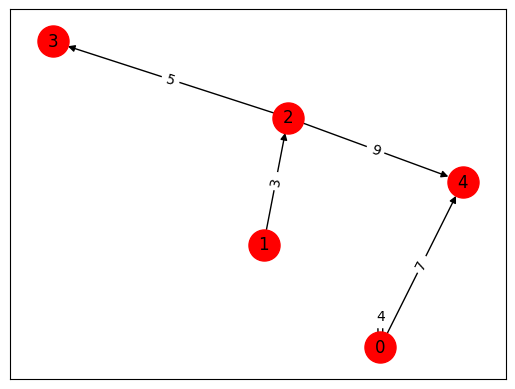

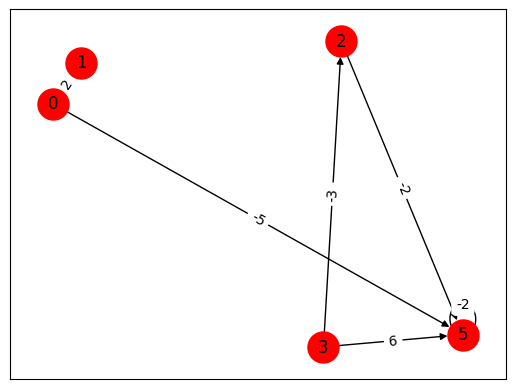

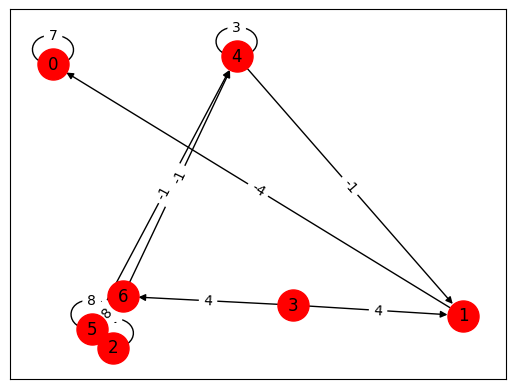

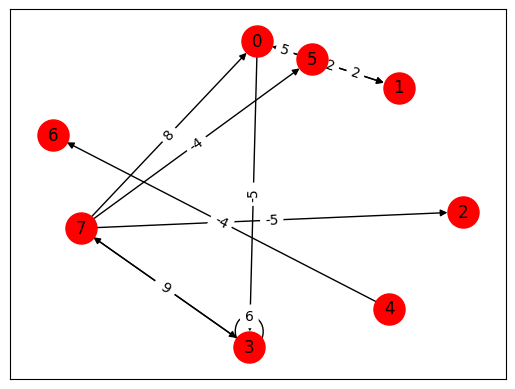

In [3]:
test_graphs_params = [(5, 0.2), (6, 0.2), (7, 0.2), (8, 0.2)]
test_graphs = [random_graph(*pair) for pair in test_graphs_params]
for graph in test_graphs:
    gb.viz.draw(graph)

# 1. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).

In [4]:
def Bellman_Ford_single_vertex(A, vertex):
    n_vertexs = A.nrows
    v = Vector(A.dtype, n_vertexs)
    v[vertex] << 0
    w = v.dup()
    for i in range(n_vertexs - 1):
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    w_old = w.dup()
    w(binary.min) << w.vxm(A, semiring.min_plus)
    if not w.isequal(w_old):
        print("There is a cycle of negative weight")
        return None
    result = []
    for i in range(n_vertexs):
        if w[i].value is None:
            result.append(float('inf'))
        else:
            result.append(w[i].value)
    return result

# 2.Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.

In [5]:
def Bellman_Ford_many_vertex(A, vertex_list):
    n_vertexs, n_start_vertexs = A.nrows, len(vertex_list)
    v = Matrix(dtypes.INT32, n_start_vertexs, n_vertexs)
    for i in range(n_start_vertexs):
        v[i, vertex_list[i]] << 0
    w = v.dup()
    for i in range(n_vertexs - 1):
        w_old = w.dup()
        for i in range(n_start_vertexs):
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    w_old = w.dup()
    for i in range(n_start_vertexs):
        w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
    if not w.isequal(w_old):
        print("There is a cycle of negative weight")
        return None
    result = {}
    for i in range(n_start_vertexs):
        buff = []
        for j in range(n_vertexs):
            if w[i, j].value is None:
                buff.append(float('inf'))
            else:
                buff.append(w[i, j].value)
        result[vertex_list[i]] = buff
    return result

# 3.Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания).

In [6]:
def FloydWarshall(A):
    n_vertexs = A.nrows
    w = A.dup()
    buff = A.dup()
    for i in range(n_vertexs):
        buff_col = Matrix(dtypes.INT32, n_vertexs, n_vertexs)
        buff_row = Matrix(dtypes.INT32, n_vertexs, n_vertexs)
        buff_col[:, i] = w[:, i].dup()
        buff_row[i, :] = w[i, :].dup()
        buff = buff_col.mxm(buff_row, semiring.min_plus)
        w << w.ewise_add(buff, op="min")

    w_check = w.dup()
    buff_w = buff.dup()
    buff_col = Matrix(dtypes.INT32, n_vertexs, n_vertexs)
    buff_row = Matrix(dtypes.INT32, n_vertexs, n_vertexs)
    buff_col[:, n_vertexs - 1] = buff_w[:, n_vertexs - 1].dup()
    buff_row[n_vertexs - 1, :] = buff_w[n_vertexs - 1, :].dup()

    if not w.isequal(w_check.ewise_add(buff_col.mxm(buff_row, semiring.min_plus), op="min")):
        print("There is a cycle of negative weight")
        return None

    result = []
    for i in range(n_vertexs):
        buff = []
        for j in range(n_vertexs):
            if i == j:
                buff.append(0)
            elif w[i, j].value is None:
                buff.append(float('inf'))
            else:
                buff.append(w[i, j].value)
        result.append(np.array(buff))
    return result

In [7]:
def TransitiveClosure(A):
    n_vertexs = A.nrows
    w = Matrix(dtypes.INT32, n_vertexs, n_vertexs)
    w.setdiag(1)
    w_start = w.dup()
    for i in range(n_vertexs):
        w_old = w.dup()
        w = w.mxm(A, semiring.min_plus).ewise_add(w_start, op="min")
        if w_old.isequal(w):
            break

    w_old = w.dup()
    w = w.mxm(A, semiring.min_plus).ewise_add(w_start, op="min")

    if not w_old.isequal(w):
        print("There is a cycle of negative weight")
        return None

    result = []

    for i in range(n_vertexs):
        buff = []
        for j in range(n_vertexs):
            if w[i, j].value is None:
                buff.append(float('inf'))
            elif i == j:
                buff.append(0)
            else:
                buff.append(w[i, j].value - 1)
        result.append(np.array(buff))
    return result

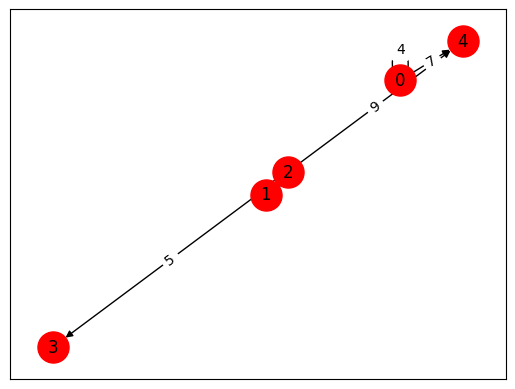

Bellman_Ford_single [0, inf, inf, inf, 7]
Bellman_Ford_many {0: [0, inf, inf, inf, 7], 3: [inf, inf, inf, 0, inf], 4: [inf, inf, inf, inf, 0]}
FloydWarshall [array([ 0., inf, inf, inf,  7.]), array([inf,  0.,  3.,  8., 12.]), array([inf, inf,  0.,  5.,  9.]), array([inf, inf, inf,  0., inf]), array([inf, inf, inf, inf,  0.])]
TransitiveClosure [array([ 0., inf, inf, inf,  7.]), array([inf,  0.,  3.,  8., 12.]), array([inf, inf,  0.,  5.,  9.]), array([inf, inf, inf,  0., inf]), array([inf, inf, inf, inf,  0.])]
Bellman_Ford test 0
Bellman_Ford test 1
Bellman_Ford test 2
Bellman_Ford test 3
Bellman_Ford test 4


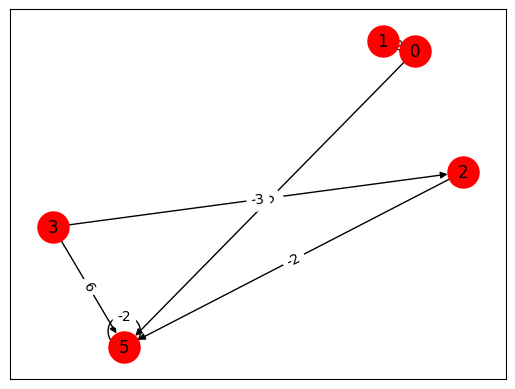

There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford_single None
Bellman_Ford_many None
FloydWarshall None
TransitiveClosure None
Bellman_Ford test 0
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford test 1
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford test 2
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford test 3
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford test 4
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight


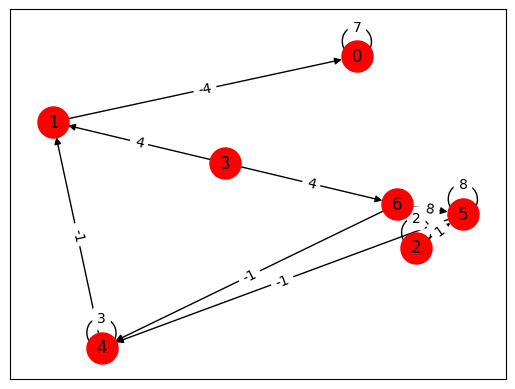

Bellman_Ford_single [0, inf, inf, inf, inf, inf, inf]
Bellman_Ford_many {0: [0, inf, inf, inf, inf, inf, inf], 3: [-2, 2, inf, 0, 3, 12, 4], 4: [-5, -1, inf, inf, 0, inf, inf]}
FloydWarshall [array([ 0., inf, inf, inf, inf, inf, inf]), array([-4.,  0., inf, inf, inf, inf, inf]), array([-5., -1.,  0., inf,  0.,  1., inf]), array([-2.,  2., inf,  0.,  3., 12.,  4.]), array([-5., -1., inf, inf,  0., inf, inf]), array([-6., -2., inf, inf, -1.,  0., inf]), array([-6., -2., inf, inf, -1.,  8.,  0.])]
TransitiveClosure [array([ 0., inf, inf, inf, inf, inf, inf]), array([-4.,  0., inf, inf, inf, inf, inf]), array([-5., -1.,  0., inf,  0.,  1., inf]), array([-2.,  2., inf,  0.,  3., 12.,  4.]), array([-5., -1., inf, inf,  0., inf, inf]), array([-6., -2., inf, inf, -1.,  0., inf]), array([-6., -2., inf, inf, -1.,  8.,  0.])]
Bellman_Ford test 0
Bellman_Ford test 1
Bellman_Ford test 2
Bellman_Ford test 3
Bellman_Ford test 4


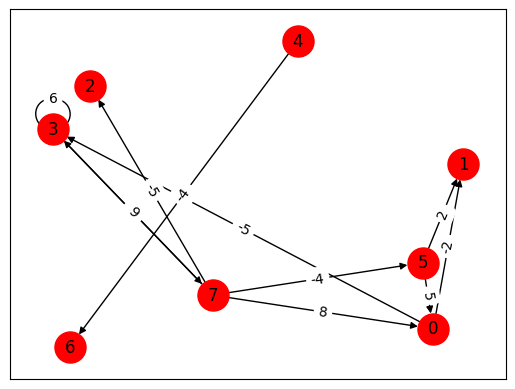

There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford_single None
Bellman_Ford_many None
FloydWarshall None
TransitiveClosure None
Bellman_Ford test 0
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford test 1
Bellman_Ford test 2
Bellman_Ford test 3
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Bellman_Ford test 4
There is a cycle of negative weight
There is a cycle of negative weight
There is a cycle of negative weight
Тесты пройдены!


In [8]:
for graph in test_graphs:
    gb.viz.draw(graph)
    bf_single = Bellman_Ford_single_vertex(graph, 0)
    bf_many = Bellman_Ford_many_vertex(graph, [0, 3, 4])
    floyd_washall = FloydWarshall(graph)
    tr_closure = TransitiveClosure(graph)
    print("Bellman_Ford_single", bf_single)
    print("Bellman_Ford_many", bf_many)
    print("FloydWarshall", floyd_washall)
    print("TransitiveClosure", tr_closure)
    # тесты
    for i in range(5):
        print(f"Bellman_Ford test {i}")
        if Bellman_Ford_single_vertex(graph, [i]) is None or Bellman_Ford_many_vertex(graph, [i]) is None:
            assert Bellman_Ford_single_vertex(graph, [i]) is None and Bellman_Ford_many_vertex(graph, [i]) is None
            continue
        assert Bellman_Ford_single_vertex(graph, i) == Bellman_Ford_many_vertex(graph, [i])[i]

    if FloydWarshall(graph) is None or TransitiveClosure(graph) is None:
        assert FloydWarshall(graph) is None and TransitiveClosure(graph) is None
        continue
    for res_1, res_2 in zip(FloydWarshall(graph), TransitiveClosure(graph)):
        assert all(res_1 == res_2)
print("Тесты пройдены!")

Также просматриваем результаты глазами и видим, что получили корректные результаты

# 4.Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [10]:
arr = ssgetpy.search(nzbounds=(400, 1000), isspd=True, limit=10)
arr

23,HB,bcsstk01,48,48,400,real,Yes,Yes,1.0,1.0,structural problem,
25,HB,bcsstk03,112,112,640,real,Yes,Yes,1.0,1.0,structural problem,
44,HB,bcsstk22,138,138,696,real,Yes,Yes,1.0,1.0,structural problem,
61,HB,bcsstm06,420,420,420,real,Yes,Yes,1.0,1.0,structural problem,
69,HB,bcsstm19,817,817,817,real,Yes,Yes,1.0,1.0,structural problem,
70,HB,bcsstm20,485,485,485,real,Yes,Yes,1.0,1.0,structural problem,
220,HB,nos4,100,100,594,real,Yes,Yes,1.0,1.0,structural problem,


In [11]:
arr.download(extract = True, destpath = "./mtx_files")

Overall progress:   0%|          | 0/7 [00:00<?, ?it/s]

bcsstk01:   0%|          | 0/1812 [00:00<?, ?B/s]

bcsstk03:   0%|          | 0/2881 [00:00<?, ?B/s]

bcsstk22:   0%|          | 0/3371 [00:00<?, ?B/s]

bcsstm06:   0%|          | 0/3270 [00:00<?, ?B/s]

bcsstm19:   0%|          | 0/6539 [00:00<?, ?B/s]

bcsstm20:   0%|          | 0/4217 [00:00<?, ?B/s]

nos4:   0%|          | 0/1760 [00:00<?, ?B/s]

In [12]:
mtx_files = glob.glob("mtx_files/*/*.mtx")
big_graphs_list = [mmread(path).dup(dtype=dtypes.BOOL).dup(dtype=dtypes.UINT8) for path in mtx_files]
shutil.rmtree("mtx_files")